In [1]:
BGC_type = 'T2PKS'

In [2]:
import os
from os import listdir, mkdir
from os.path import isfile, join
import pandas as pd
from pathlib import Path
#import plotnine #currently installed in home. Should better be under project, but couldn't figure it out
from plotnine import ggplot, aes, geom_point, geom_text, scale_x_continuous, scale_y_continuous, geom_smooth

So far this assumes that antismash results for positive and negative base genomes exist already, otherwise include a step here that sends off a slurm job for antismash.

Requires:
- coverage tables (add script that puts them together)
- metabgc quantify results (unique-biosynthetic-reads-abundance-table-wide.txt)

In [3]:
# Helper function for making directories only if they don't exist yet
def makedir(dirpath):
    if os.path.isdir(dirpath):
        print(dirpath,'exists already')
    else:
        print('Making', dirpath)    
        os.mkdir(dirpath)

        
# Defining paths for required directory structure for input and output files relative to parent directory
parent_dir='/nesi/project/vuw03285/'+BGC_type
coverage_table_path=os.path.join(parent_dir, 'coverage_tables')
metabgc_quantify_path=os.path.join(parent_dir, 'mbgc_quantify_results')
results_path=os.path.join(parent_dir, 'results')


# Calling function to make directories if they don't exist yet
makedir(parent_dir)
makedir(coverage_table_path)
makedir(metabgc_quantify_path)
makedir(results_path)

/nesi/project/vuw03285/T2PKS exists already
/nesi/project/vuw03285/T2PKS/coverage_tables exists already
/nesi/project/vuw03285/T2PKS/mbgc_quantify_results exists already
/nesi/project/vuw03285/T2PKS/results exists already


In [4]:
# Parses mbgc quantify output tables and generates a dataframe that links each input genome 
#to the amount of unique biosynthetic reads found.

os.chdir(metabgc_quantify_path)

#list filenames in mbgc directory
filenames = [f for f in listdir(metabgc_quantify_path) if isfile(join(metabgc_quantify_path, f))]


# As all files the quantify result files come out of mbgc with an identical filename, it is required that the
# filenames are changed in such a way that they are unique before copying all these files into the metabgc_quantify_path.
# Simply append the name of the directory they are contained in to the filename, e.g.:
# unique-biosynthetic-reads-abundance-table-wide_7375_S148.txt
# This in turn has to match the name of the coverage table file that the synthetic metagenome is based on.
# See the matching sample in the cell below.
mbgc_dict = {}
for file in filenames:
    key = '_'.join(file.split('_')[-2:]).strip('.txt')
    with open(file) as f:
        read_count=0
        for i, l in enumerate(f):
            read_count +=1
            pass
    mbgc_dict[key] = read_count-1

count_df = pd.DataFrame.from_dict(mbgc_dict,orient='index').reset_index()
count_df.columns = ['metagenome', 'mbgc_count']
print(count_df.head())

    metagenome  mbgc_count
0  7375_S39313         234
1   7375_S5507         185
2      7375_S6          67
3     7375_S72         217
4      7375_S8          41


In [5]:
os.chdir(coverage_table_path)

cov_table_files = [f for f in listdir(coverage_table_path) if isfile(join(coverage_table_path, f))]
#for count, value in enumerate(cov_table_files):
#    print(count,value)

# This requires that the coverage table filename follows a certain naming convention so that the metagenome name
# Can be parsed out of it and a dataframe be built by mapping based on this name
# naming: pos-genomes_neg-genomes_metagenome-name_metagenome-number.csv, e.g. 0_15_7375_S148.csv
pos_genomes_dict = {}
for file in cov_table_files:
    key = '_'.join(file.split('_')[-2:]).strip('.csv')
    value = file.split('_')[0]
    pos_genomes_dict[key] = value
    
count_df['pos_genomes_count'] = count_df['metagenome'].map(pos_genomes_dict)

# At the moment, this parses more information out of the files than necessary for the following plot
# This is a remnant of previouly plotting different metrics against each other before settling on this one
# However, they might still be of interest.
genome_names_dict = {}
coverage_dict = {}
for file in cov_table_files:
    key = '_'.join(file.split('_')[-2:]).strip('.csv')
    with open(file) as f:
        line = f.readlines()
        genome_names_list = []
        coverage_sum = 0
        for i in line:
            # This currently assumes that positive genomes start with GCF_ (neg with GCA_) which is not ideal
            # This needs to be pre-defined in some way.
            if i.split(',')[2].startswith('GCF_') and float(i.split(',')[-1:][0].strip('\n')) != 0:
                genome_names_list.append(i.split(',')[2].strip('.fasta'))
                coverage_sum += float(i.split(',')[-1:][0].strip('\n'))
                
            genome_names_dict[key] = genome_names_list
            coverage_dict[key] = coverage_sum


#genome names disregarded, for now assuming that each genome has only 1 cluster of interest
count_df['coverage_sum'] = count_df['metagenome'].map(coverage_dict)
count_df['pos_genome_names'] = count_df['metagenome'].map(genome_names_dict)

count_df.to_csv(results_path+'/count_df.tsv', sep='\t',index=False)

print(count_df)

     metagenome  mbgc_count pos_genomes_count  coverage_sum  \
0   7375_S39313         234                 9     69.193904   
1    7375_S5507         185                 8     34.175461   
2       7375_S6          67                 5     13.193951   
3      7375_S72         217                 6     59.413199   
4       7375_S8          41                 3      7.094211   
5       7375_S3          41                 2      5.427617   
6       7375_S1          14                 0      0.000000   
7     7375_S228           2                 0      0.000000   
8      7375_S13          17                 1      3.947681   
9      7375_S20          32                 2      5.321996   
10      7375_S4         108                 6     20.944076   
11  7375_S93953         133                 9     22.468825   
12  7375_S10977         145                 9     31.118832   
13     7375_S10          71                 5     14.764804   
14      7375_S2          64                 2     12.28

In [6]:
#This produces a replica of Fig. S9 of the 2019 Sugimoto paper and saves it

p=(
     ggplot(count_df)
     + aes(x=count_df.loc[:,'coverage_sum'], y=count_df.loc[:,'mbgc_count'], label = count_df.loc[:,'pos_genomes_count'])
     + geom_point()
     + geom_text(nudge_y = 10, size=8)
     + scale_x_continuous()
     + scale_y_continuous()
     + geom_smooth(method='lm', inherit_aes=True, alpha=0.25, size=0.25, color='red', se=True)
)

p.save(results_path+'/comparison.png', height=5, width=7, units = 'in', dpi=300)

/home/blankma/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 5 in image.
/home/blankma/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /nesi/project/vuw03285/T2PKS/results/comparison.png


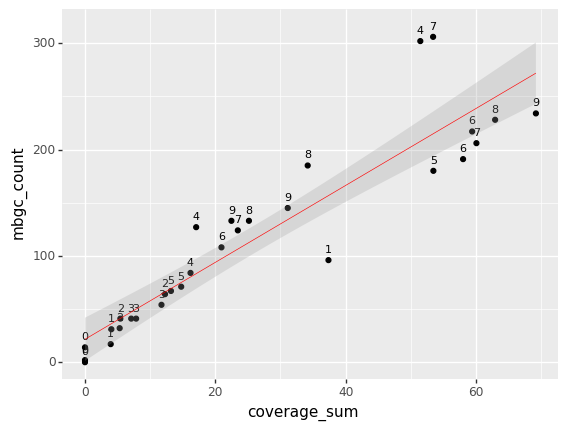

<ggplot: (2932120023028)>

In [7]:
#This shows the same plot

(
     ggplot(count_df)
     + aes(x=count_df.loc[:,'coverage_sum'], y=count_df.loc[:,'mbgc_count'], label = count_df.loc[:,'pos_genomes_count'])
     + geom_point()
     + geom_text(nudge_y = 10, size=8)
     + scale_x_continuous()
     + scale_y_continuous()
     + geom_smooth(method='lm', inherit_aes=True, alpha=0.25, size=0.25, color='red', se=True)
)